## Poročilo vaja 6.2 

#### Regresija: Multipla logistična regresija

Izvedite model multiple logistične regresije (MLR) na podatkih za ugotavljanje faktorjev tveganja za poškodbo pri rekreativnih tekačih *running_injury.sav*.
1. Najprej izvedite posamične analize faktorjev tveganja za poškodbe pri rekreativnih tekačih z uporabo osnovnih statistik tveganja.
2. Nato izvedite model logistične regresije.
   - Komentirajte rezultate modela
   - Primerjajte rezultate modela s posamičnimi statistikami iz prejšnje točke.
3. Evaluacija modela:
   - Primerjajte uspešnost napovedovanja modela z ROC analizo. To izvedite na pravilen način, kjer podatke razdelite na učno in testno množico.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import shapiro, chi2_contingency, ttest_ind
from scipy.stats.contingency import odds_ratio
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

path = os.getcwd()
df = pd.read_spss(path + "\\data\\running_injury.sav")

df['poskodba'] = df['poskodba']
df['poskodba_da_ne'] = df['poskodba_da_ne'].map({'da':1, 'ne':0}).astype(int)
df['ogrevanje'] = df['ogrevanje'].map({'da': 1, 'ne': 0})
df['vaje'] = df['vaje'].map({'da': 1, 'ne': 0})
df['BMI26'] = df['BMI26'].map({'< 26': 0, '> 26': 1}).astype(int)
df['izkusnje10'] = df['izkusnje10'].map({'<10 let': 0, '>10 let': 1}).astype(int)
df['spol'] = df['spol'].map({'M': 0, 'Ž': 1})

df.head()

,spol,starost,BMI,BMI26,tedenski_km,povp_hitrost,stopalo,izkusnje10,ogrevanje,vaje,poskodba,poskodba_da_ne
0,0,48.0,22.08,0,19.433198,12.492228,nevtralno,0,0,0,7 dni,1
1,0,52.0,24.00,0,18.947368,8.257113,nevtralno,0,0,0,0 dni,0
2,1,52.0,20.19,0,12.388664,12.734525,pronacija,0,0,0,0 dni,0
3,1,43.0,27.92,1,10.688259,13.268042,nevtralno,0,0,0,8-28 dni,1
4,0,55.0,26.93,1,18.218623,9.653424,nevtralno,0,0,0,7 dni,1


Najprej naredimo neodvisni t-test za numerične spremenljivke (starost, tedenski kilometri in povprečna hitrost), nato naredimo še hi-kvadrat test za kategorijske spremenljivke.

In [3]:
print("\n=== T-testi za numerične spremenljivke ===")
for var in ['starost', 'tedenski_km', 'povp_hitrost']:
    group1 = df[df['poskodba_da_ne'] == 1][var]
    group2 = df[df['poskodba_da_ne'] == 0][var]
    t_stat, p = ttest_ind(group1, group2, equal_var=False)
    print(f"{var}: t = {t_stat:.2f}, p = {p:.4f}")
    print(f"Srednja poškodovani: {group1.mean():.2f}, nepoškodovani: {group2.mean():.2f}")
    print()

print("\n=== Hi-kvadrat testi za kategorijske spremenljivke ===")
for cat in ['spol', 'BMI26', 'stopalo', 'izkusnje10', 'ogrevanje', 'vaje']:
    tbl = pd.crosstab(df[cat], df['poskodba_da_ne'])
    chi2, p, dof, exp = chi2_contingency(tbl)
    print(f"\n{cat}:\nChi2 = {chi2:.3f}, p = {p:.3f}")
    print(tbl)



=== T-testi za numerične spremenljivke ===
starost: t = -1.39, p = 0.1653
Srednja poškodovani: 43.59, nepoškodovani: 45.13

tedenski_km: t = 5.32, p = 0.0000
Srednja poškodovani: 28.65, nepoškodovani: 21.31

povp_hitrost: t = 1.63, p = 0.1035
Srednja poškodovani: 11.45, nepoškodovani: 11.08


=== Hi-kvadrat testi za kategorijske spremenljivke ===

spol:
Chi2 = 0.124, p = 0.725
poskodba_da_ne    0   1
spol                   
0               111  55
1                62  35

BMI26:
Chi2 = 5.917, p = 0.015
poskodba_da_ne    0   1
BMI26                  
0               120  48
1                53  42

stopalo:
Chi2 = 0.996, p = 0.608
poskodba_da_ne   0   1
stopalo               
nevtralno       85  50
pronacija       67  30
supinacija      21  10

izkusnje10:
Chi2 = 0.037, p = 0.847
poskodba_da_ne    0   1
izkusnje10             
0               134  68
1                39  22

ogrevanje:
Chi2 = 7.306, p = 0.007
poskodba_da_ne    0   1
ogrevanje              
1                62  17
0    

**Interpretacija:** Iz rezultatov lahko ugotovimo, da na poškodbo vpliva več faktorjev: število pretečenih kilometrov na teden, BMI, ogrevanje pred tekom in opravljanje vaj. Ker na poškodbo vpliva več faktorjev lahko na podatkih izvedemo model logistične regresije.

In [4]:
df_dummies = pd.get_dummies(df, columns=['stopalo'])
X_cols = ['spol', 'BMI26', 'izkusnje10', 'ogrevanje', 'vaje', 
          'stopalo_pronacija', 'stopalo_supinacija', 'stopalo_nevtralno', 
          'starost', 'tedenski_km', 'povp_hitrost']
df_dummies['stopalo_pronacija'] = df_dummies['stopalo_pronacija'].map({True: 1, False: 0})
df_dummies['stopalo_supinacija'] = df_dummies['stopalo_supinacija'].map({True: 1, False: 0})
df_dummies['stopalo_nevtralno'] = df_dummies['stopalo_nevtralno'].map({True: 1, False: 0})
display(df_dummies.head())
X = df_dummies[X_cols]
X = sm.add_constant(X)
y = df_dummies['poskodba_da_ne']

model = sm.Logit(y, X).fit()
print("\n=== Logistična regresija ===")
print(model.summary())


,spol,starost,BMI,BMI26,tedenski_km,povp_hitrost,izkusnje10,ogrevanje,vaje,poskodba,poskodba_da_ne,stopalo_nevtralno,stopalo_pronacija,stopalo_supinacija
0,0,48.0,22.08,0,19.433198,12.492228,0,0,0,7 dni,1,1,0,0
1,0,52.0,24.00,0,18.947368,8.257113,0,0,0,0 dni,0,1,0,0
2,1,52.0,20.19,0,12.388664,12.734525,0,0,0,0 dni,0,0,1,0
3,1,43.0,27.92,1,10.688259,13.268042,0,0,0,8-28 dni,1,1,0,0
4,0,55.0,26.93,1,18.218623,9.653424,0,0,0,7 dni,1,1,0,0


Optimization terminated successfully.
         Current function value: 0.533367
         Iterations 21

=== Logistična regresija ===
                           Logit Regression Results                           
Dep. Variable:         poskodba_da_ne   No. Observations:                  263
Model:                          Logit   Df Residuals:                      252
Method:                           MLE   Df Model:                           10
Date:                Fri, 20 Jun 2025   Pseudo R-squ.:                  0.1698
Time:                        12:03:53   Log-Likelihood:                -140.28
converged:                       True   LL-Null:                       -168.97
Covariance Type:            nonrobust   LLR p-value:                 1.123e-08
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.4852        nan        nan        na

**Interpretacija:** Opazimo lahko, da model logistične regresije kot statistično pomembne faktorje za tveganje poškodbe navede enake faktorje kot posamezni hi-kvadrat in t testi. Opravimo še ROC analizo.

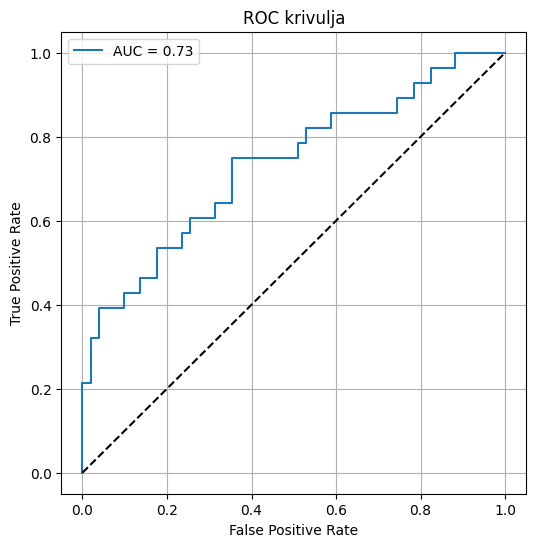

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model_train = sm.Logit(y_train, X_train).fit(disp=0)
y_pred_prob = model_train.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC krivulja")
plt.legend()
plt.grid()
plt.show()

ROC analizo uporabljamo za evaluacijo učinkovitosti binarnega klasifikacijskega modela (razvrščamo v dve kategoriji; poškodba da/ne). ROC krivulja prikazuje delež lažno pozitivnih primerov (x-os) in delež resnično pozitivnih primerov (y-os). Popoln model bi šel skozi točko (0, 1), kar bi pomenilo, da vedno pravilno napove pozitiven primer. AUC (površina pod krivuljo) je število na intervalu med 0 in 1 in pove kako dobro model ločuje med razredi. V našem primeru je AUC = 0.73, kar pomeni dober model, ki v 73% primerov pravilno napove rezultat, vendar je tak model potrebno izboljšati preden bo primeren za praktično uporabo.